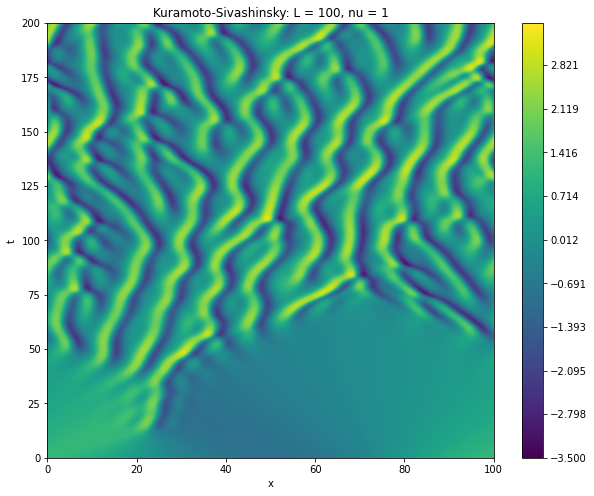

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.pyplot import cm
import cmasher as cmr

nu = 1
L = 100 
nx = 1024

t0 = 0 
tN = 200
dt = 0.05
nt = int((tN - t0) / dt)

# wave number mesh (multiply back by nx because fftfreq takes it out - we raise k to powers so it affects us and has to be accounted for)
k = (2 * np.pi / L) * np.fft.fftfreq(nx) * nx

t = np.linspace(t0, tN, nt)
x = np.linspace( 0, L,  nx)

# solution mesh in real and Fourier space
u      = np.empty((nt, nx))
u_hat  = np.empty((nt, nx), dtype=np.complex64)
u_hat2 = np.empty((nt, nx), dtype=np.complex64)

# set initial condition in real and Fourier space
u[0]      = np.cos((2 * np.pi * x) / L) + 0.1 * np.cos((4 * np.pi * x) / L)
u_hat[0]  = (1 / nx) * np.fft.fft(u[0])
u_hat2[0] = (1 / nx) * np.fft.fft(u[0]**2)

# Fourier Transform of the linear and nonlinear operators
FL = (k ** 2) - nu * (k ** 4)
FN = - (1 / 2) * (1j) * k

# Crank-Nicholson algebraic relations between uhat[n+1] and uhat[n]
CN1 = (1 + (dt / 2) * FL)
CN2 = 1 / (1 - (dt / 2) * FL)

# first timestep (no advanced restarting, just Euler)
u_hat[1]  = CN2 * ( CN1 * u_hat[0] + FN * u_hat2[0] * dt)

# auxiliaries of first timestep
u[1]      = nx * np.real(np.fft.ifft(u_hat[1]))
u_hat2[1] = (1 / nx) * np.fft.fft(u[1]**2)

# compute solution through time via finite difference method in Fourier space
for j in range(1,nt-1): 
  # Cranck-Nicholson + Adams-Bashforth
  u_hat[j+1]  = CN2 * ( CN1 * u_hat[j] + ( 1.5 * FN * u_hat2[j] - 0.5 * FN * u_hat2[j-1] ) * dt)
  #u_hat[j+1, abs(k) > nx/3] = 0
  
  # go back to real space
  u[j+1]      = nx * np.real(np.fft.ifft(u_hat[j+1]))
  u_hat2[j+1] = (1 / nx) * np.fft.fft(u[j+1]**2)

# plot the result
fig, ax = plt.subplots(figsize=(10,8))

xx, tt = np.meshgrid(x, t)
levels = np.linspace(-3.5, 3.5, 300)
cs = ax.contourf(xx, tt, u, levels, cmap=cm.viridis)
fig.colorbar(cs)

ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_title(f"Kuramoto-Sivashinsky: L = {L}, nu = {nu}")

u_np = u

Text(0.5, 1.0, 'Kuramoto-Sivashinsky: L = 100, nu = 1')

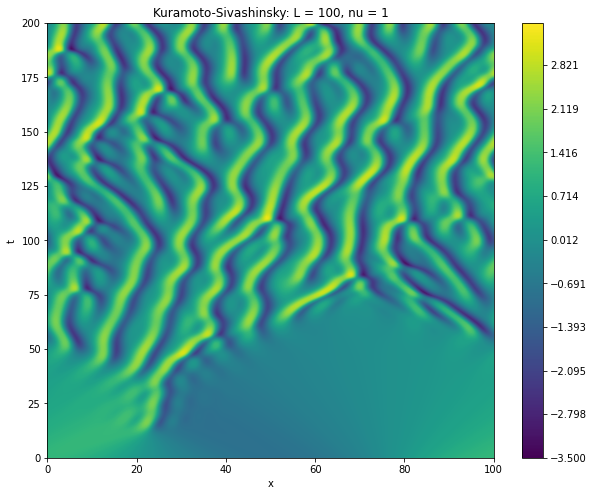

In [2]:
import jax
import jax.numpy as jnp
from jax.numpy.fft import fft, ifft, fftfreq
from jax import jit

from jax.config import config
config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt

nu = 1
L = 100 
nx = 1024

t0 = 0 
tN = 200
dt = 0.05
nt = int((tN - t0) / dt)

# wave number mesh (multiply back by nx because fftfreq takes it out - we raise k to powers so it affects us and has to be accounted for)
k = (2 * jnp.pi / L) * fftfreq(nx) * nx

t = jnp.linspace(t0, tN, nt)
x = jnp.linspace( 0, L,  nx)

# solution mesh in real and Fourier space
u      = jnp.empty((nt, nx), dtype=jnp.float64)
u_hat  = jnp.empty((nt, nx), dtype=jnp.complex128)
u_hat2 = jnp.empty((nt, nx), dtype=jnp.complex128)

# set initial condition in real and Fourier space
u      = u     .at[0].set( jnp.cos((2 * jnp.pi * x) / L) + 0.1 * jnp.cos((4 * jnp.pi * x) / L) )
u_hat  = u_hat .at[0].set( (1 / nx) * fft(u[0])    )
u_hat2 = u_hat2.at[0].set( (1 / nx) * fft(u[0]**2) )

# Fourier Transform of the linear and nonlinear operators
FL = (k ** 2) - nu * (k ** 4)
FN = - (1 / 2) * (1j) * k

# Crank-Nicholson algebraic relations between uhat[n+1] and uhat[n]
CN1 = (1 + (dt / 2) * FL)
CN2 = 1 / (1 - (dt / 2) * FL)

# first timestep (no advanced restarting, just Euler)
u_hat  = u_hat .at[1].set( CN2 * ( CN1 * u_hat[0] + FN * u_hat2[0] * dt) )

# auxiliaries of first timestep
u      = u     .at[1].set( nx * jnp.real(ifft(u_hat[1])) )
u_hat2 = u_hat2.at[1].set( (1 / nx) * fft(u[1]**2)       )

# compute solution through time via finite difference method in Fourier space
for j in range(1,nt-1): 
  # Cranck-Nicholson + Adams-Bashforth
  u_hat  = u_hat.at[j+1].set( CN2 * ( CN1 * u_hat[j] + ( 1.5 * FN * u_hat2[j] - 0.5 * FN * u_hat2[j-1] ) * dt) )
  
  # go back to real space
  u      = u     .at[j+1].set( nx * jnp.real(ifft(u_hat[j+1])) )
  u_hat2 = u_hat2.at[j+1].set( (1 / nx) * fft(u[j+1]**2)       )

# plot the result
fig, ax = plt.subplots(figsize=(10,8))

xx, tt = jnp.meshgrid(x, t)
levels = jnp.linspace(-3.5, 3.5, 300)
cs = ax.contourf(xx, tt, u, levels)
fig.colorbar(cs)

ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_title(f"Kuramoto-Sivashinsky: L = {L}, nu = {nu}")

Text(0.5, 1.0, 'Kuramoto-Sivashinsky: L = 100, nu = 1')

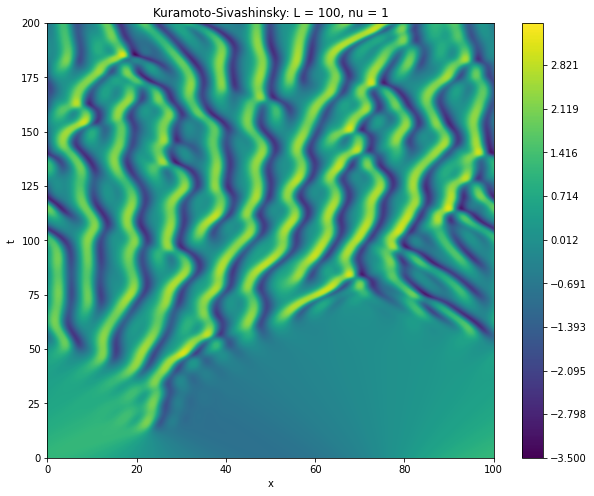

In [1]:
import jax
import jax.numpy as jnp
from jax.numpy.fft import fft, ifft, fftfreq
from jax import jit

from jax.config import config
config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt

nu = 1
L = 100 
nx = 1024 * 2

t0 = 0 
tN = 200
dt = 0.05
nt = int((tN - t0) / dt)

# wave number mesh (multiply back by nx because fftfreq takes it out - we raise k to powers so it affects us and has to be accounted for)
k = (2 * jnp.pi / L) * fftfreq(nx) * nx

t = jnp.linspace(t0, tN, nt)
x = jnp.linspace( 0, L,  nx)

# solution mesh in real and Fourier space
u = jnp.empty((3, nt, nx), dtype=jnp.complex128)

# terrible variable convention, but necessary for JAX compilation:
# u[0] = u   in real space
# u[1] = u   in fourier space
# u[2] = u^2 in fourier space

# set initial condition in real and Fourier space
u = u.at[0,0].set( jnp.cos((2 * jnp.pi * x) / L) + 0.1 * jnp.cos((4 * jnp.pi * x) / L) )
u = u.at[1,0].set( (1 / nx) * fft(u[0,0])    )
u = u.at[2,0].set( (1 / nx) * fft(u[0,0]**2) )

# Fourier Transform of the linear and nonlinear operators
FL = (k ** 2) - nu * (k ** 4)
FN = - (1 / 2) * (1j) * k

# Crank-Nicholson algebraic relations between uhat[n+1] and uhat[n]
CN1 = (1 + (dt / 2) * FL)
CN2 = 1 / (1 - (dt / 2) * FL)

# first timestep (no advanced restarting, just Euler)
u = u.at[1,1].set( CN2 * ( CN1 * u[1,0] + FN * u[2,0] * dt) )

# auxiliaries of first timestep
u = u.at[0,1].set( nx * jnp.real(ifft(u[1,1])) )
u = u.at[2,1].set( (1 / nx) * fft(u[0,1]**2)   )


def finite_step(j,u):
  # Cranck-Nicholson + Adams-Bashforth
  u = u.at[1,j+1].set( CN2 * ( CN1 * u[1,j] + ( 1.5 * FN * u[2,j] - 0.5 * FN * u[2,j-1] ) * dt) )
  
  # go back to real space
  u = u.at[0,j+1].set( nx * jnp.real(ifft(u[1,j+1])) )
  u = u.at[2,j+1].set( (1 / nx) * fft(u[0,j+1]**2)   )

  return u

# compute solution through time via finite difference method in Fourier space
u = jax.lax.fori_loop(1,nt-1,finite_step,u)  

# plot the result
fig, ax = plt.subplots(figsize=(10,8))

xx, tt = jnp.meshgrid(x, t)
levels = jnp.linspace(-3.5, 3.5, 300)
cs = ax.contourf(xx, tt, jnp.real(u[0]), levels)
fig.colorbar(cs)

ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_title(f"Kuramoto-Sivashinsky: L = {L}, nu = {nu}")

Text(0.5, 1.0, 'KS difference b/w Numpy and JAX: L = 100, nu = 1')

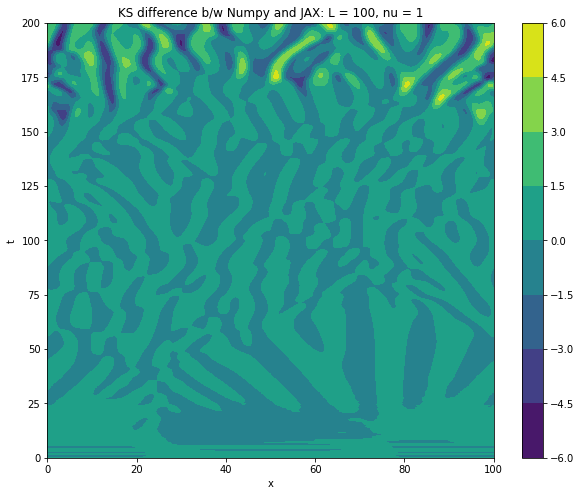

In [15]:
fig, ax = plt.subplots(figsize=(10,8))
cs = ax.contourf(xx, tt, u_np - jnp.real(u[0]))
fig.colorbar(cs)

ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_title(f"KS difference b/w Numpy and JAX: L = {L}, nu = {nu}")